# Applied Data Science Capstone: most similar neighbourhood in another city
*by Eduardo M. de Morais*


# 1. Introduction

## 1.1 Background

São Paulo and Rio de Janeiro are the two largest cities in Brazil. Although relatively close (given the continental dimensions of the country), they have very different characteristics. One of the factors that contribute to the existence of these discrepancies is the obvious geographical distinctions that naturally shape social behavior and, indirectly, the urban structural configuration. The beaches of Rio de Janeiro, for example, give residents a natural option of entertainment and the nearest commercial places have characteristics aimed at this purpose. On the other hand, in São Paulo, entertainment options are directly dependent on experiences that can be provided as a business model.

From a social point of view, Rio de Janeiro inherits aristrocratic characteristics, for having long been the capital of the empire of Brazil. In contrast, the history behind São Paulo's growth is much more associated with commercial reasons. For this reason, the lifestyle in São Paulo tends to be much more pragmatic than in Rio de Janeiro. This characteristic also influences the business model, as there are many more establishments in São Paulo that provide what people do not have time to do.

## 1.2 Problem

We have two of the largest cities in the world with very distinct characteristics: São Paulo and Rio de Janeiro. Locally, each of this places acts like professional centers attracting professionals and companies. Despite the differences mentioned, it is expected that several specific neighborhoods of these cities have characteristics in common. One way to look for this similarity would be to consider the types of venues in each neighborhood. In this way, it would be possible to detect whether a neighborhood has characteristics more focused on commerce, leisure, sports, culture or housing. So, what we need here is a procedure capable of relating neighborhoods, not only from the same city, but also from different cities.


## 1.3 Interest

It is very common for people to have to move to another city. The reasons for this are quite diverse and can involve professional opportunities, personal reasons, among others. This process can be quite difficult for some people, as it involves adapting to a new and possibly different environment. Although two cities may be completely different, they may have neighborhoods with similar characteristics in common. Knowledge of this information can be crucial when choosing a new place to live in a new city. Thus, a person can choose to move to a neighborhood in a new city with similar characteristics to the neighborhood in the city where he lives and is already acclimated.

 Sometimes, a company in one of this cities is interesting in a professional that lives in the other city. Certainly, if the professional find a similiar  neighbourhood, he will be more likely to accept an offer if it is professionally interesting.

# 2. Data

## 2.1 Neighbourhood List
**A** To complete our task, we will need to use some datasets for the analysis approach. First, we need to obtain a data source for the neighborhoods in each of the cities. This can be found on the website `www.guimais.com.br`:
   - (São Paulo): https://www.guiamais.com.br/bairros/sao-paulo-sp
   - (Rio de Janeiro): https://www.guiamais.com.br/bairros/rio-de-janeiro-rj
   
**B** The next step is obtain the coordinates for each neighbourhood. It can be done using the Nominatim tool, from OpenStreetMap

**C** With the neighbourhoods and its coordinates we can use de Foursquare API to get the venues in each neighbourhood.

https://pt.wikipedia.org/wiki/Lista_dos_distritos_de_S%C3%A3o_Paulo_por_%C3%8Dndice_de_Desenvolvimento_Humano

https://pt.wikipedia.org/wiki/Lista_de_bairros_do_Rio_de_Janeiro_por_IDH

# 3. Methodology

I have to follow the next steps to solve the problem:
1. Scrap the neighbourhood data from the `guiamais.com.br` using BeautifulSoup package.
2. Gets Coordinates for each Neighbourhood using **nominatim**
3. Gets the venues in each neighbourhood within a radius of 5km using **Foursquare** API. This is a good value because places at that distance can be accessed quickly by car. 
4. Count the most common categories of venues. I will consider only the categories that appears more than 100 times. After this, I  will create a feature for each of this categories checking if the number of times that it appears in each neighbourhood is more than 3. If yes, returns a 1 and 0 if no.
5. Cluster the data using KMeans, choosing a number of clusters from 3 to 8 and choose the best using a score the maximize Silhouette score, Calinski-Harabasz score and minimizes the Davies-Bouldin score.

## 3.1 Importing packages

In [1]:
import pandas as pd
import numpy as np
import re
import requests 
import folium
import pickle
import random
from bs4 import BeautifulSoup
from html import unescape
from tqdm import tqdm
from geopy.geocoders import Nominatim
from functools import reduce
from collections import Counter 

Here, I define the properties of each city and save it in a dictionary:

In [2]:
# Define here the cities and its respectives urls to
# scrap the neighbourhood list
cities = {
    'rj': {
        'name': 'Rio de Janeiro',
        'url':'https://www.guiamais.com.br/bairros/rio-de-janeiro-rj',
        'long_min': -43.694087,
        'long_max': -43.166904,
        'lat_min': -23.047039,
        'lat_max': -22.785521,
    },
    'sp':{
        'name': 'São Paulo',
        'url':'https://www.guiamais.com.br/bairros/sao-paulo-sp',
        'long_min': -46.860478,
        'long_max': -46.137922,
        'lat_min': -23.850532,
        'lat_max': -23.385265,
    }
}

## 3.2 Importing Dataset

The first step is scrap the dataset of neighbourhood information from `guiamais.com.br`. Since we have to do this more than one time, lets define a function for this. To scrap the neighbournames, we just need the url: 

### 3.2.1 Scrap Neighbourhood Information

In [3]:
def scrap_neighbourhoods_from_guiamais(url):
    """Scraps the neighbourhoods list of a city from
    a given url of guiamais.com.br site.
    """

    table = BeautifulSoup(requests.get(url).text, "lxml").find(
        "section", class_="cities centerContent"
    )

    table_string = unescape(str(table.find_all("li")))

    return re.findall('">(.*?)</a', table_string)


Now, we have to scrap the date through the cities and concatenate the information:

In [4]:
def neighbourhood_dataframe(city, neighbourhood_list):
    """ Trasform a list of neighbourhood into dataframe  """
    return pd.DataFrame(
        [(city, nb) for nb in neighbourhood_list], columns=["city", "neighbourhood"]
    )


# Scrapes neighbourhood and creates a pandas dataframe with the result
df = pd.concat(
    [
        neighbourhood_dataframe(
                cities[_]['name'],
                scrap_neighbourhoods_from_guiamais(cities[_]['url'])    
        )  for _ in cities
    ]
).reset_index(drop=True)

Printing a data sample

In [5]:
print('\n\nSample of data:')
pd.concat(
    [
        df.loc[df['city']=='Rio de Janeiro'].sample(2),
        df.loc[df['city']=='São Paulo'].sample(2),
    ]
)



Sample of data:


,city,neighbourhood
130,Rio de Janeiro,Ribeira
140,Rio de Janeiro,Santo Cristo
503,São Paulo,Vila Bandeirantes
479,São Paulo,Sítio do Mandaqui


### 3.2.2 Gets Coordinates for each Neighbourhood

For each neighbourhood, I will call the nominatim to import the coordinates.

In [6]:
def get_neighbourhood_coord(nominatim, city, neighbourhood):
    """ Gets the coordinate of a neighbourhood """
    
    try:
        location = nominatim.geocode(neighbourhood + " - " + city + ", Brazil")
        return (location.latitude, location.longitude)

    except Exception as inst:
        return (None, None)


As we are working with a large number of neighbourhoods, it is convenient to save the results in a csv file.

In [7]:
if False:
    # instantiate the Nominatim class
    geoloc = Nominatim(user_agent="test_app")

    # Gets the coordinates of all neighbourhoods
    coord_list = [
        get_neighbourhood_coord(geoloc,row['city'],row['neighbourhood']) 
         for index, row in tqdm(df.iterrows(),total = len(df))
    ]

    # Adds the coordinates to neighbourhoods dataframe
    df = pd.concat(
        [
            df,
            pd.DataFrame(coord_list,
                columns=['latitude','longitude'])
        ],
        axis=1
    )

    # Exports the result
    df.to_csv(
        'data/coord'+reduce(lambda x,y: '_'+x+'_'+y,[_ for _ in cities])+'.csv',
        index=False
    )

In [8]:
# Import the dataframe of neighbourhood
df = pd.read_csv( 'data/coord'+reduce(lambda x,y: '_'+x+'_'+y,[_ for _ in cities])+'.csv')

# create a neighbourhood index
df = df.reset_index()

# Remove all neighbourhoods without coordinates
df = df.dropna()

df.drop(index=df[(df['neighbourhood']=='Campos Elíseos') & (df['city']=='São Paulo')].index[0],inplace=True)

### 3.2.3 Gets the venues for each neighbourhood with Foursquare

In order to use the Foursquare, the first step is define the credentials. I have it in a separated csv file that I will import here:

In [9]:
CLIENT_ID,CLIENT_SECRET,ACCESS_TOKEN,VERSION = \
    pd.read_csv('data/credentials.csv').T.to_dict()[0].values()

The approach here is use the explore query from Foursquare, passing the coordinates for each neighbourhood and get the venues. Here, I will set a radius of 1.5 km and limit the search in 1000 venues. If the Foursquare do not find any venue, so the fucntion will return an empty dict.

In [10]:
def get_nearby_venues(index,
                      city,
                      neighbourhood,
                      latitude,
                      longitude,
                      radius = 1500,
                      limit = 1000):
    """ Query to explore the neighbourhood places in foursquare api """
            
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        limit)

    try:
        return {
            'index': index,
            'city': city,
            'neighbourhood': neighbourhood,
            'result': requests.get(url, timeout=5).json()["response"]['groups'][0]['items']
        }
    except:
        return {
            'index': index,
            'city': city,
            'neighbourhood': neighbourhood,
            'result': None
        }

Here, I'll print an example of output

In [11]:
results = get_nearby_venues(
    df.iloc[60]['index'],
    df.iloc[60]['city'],
    df.iloc[60]['neighbourhood'],
    df.iloc[60]['latitude'],
    df.iloc[60]['longitude'],
    radius = 5000,
    limit = 1000
)
results

{'index': 72,
 'city': 'Rio de Janeiro',
 'neighbourhood': 'Guaratiba',
 'result': [{'reasons': {'count': 0,
    'items': [{'summary': 'This spot is popular',
      'type': 'general',
      'reasonName': 'globalInteractionReason'}]},
   'venue': {'id': '5044d19fe4b08d95c2f5632e',
    'name': 'Bora Bora',
    'location': {'address': 'Estrada do Mato Alto, 3620. Guaratiba',
     'lat': -22.979256944773702,
     'lng': -43.58888687975564,
     'labeledLatLngs': [{'label': 'display',
       'lat': -22.979256944773702,
       'lng': -43.58888687975564}],
     'distance': 1324,
     'cc': 'BR',
     'city': 'Rio de Janeiro',
     'state': 'RJ',
     'country': 'Brasil',
     'formattedAddress': ['Estrada do Mato Alto, 3620. Guaratiba',
      'Rio de Janeiro, RJ',
      'Brasil']},
    'categories': [{'id': '4d954b0ea243a5684a65b473',
      'name': 'Convenience Store',
      'pluralName': 'Convenience Stores',
      'shortName': 'Convenience Store',
      'icon': {'prefix': 'https://ss3.4sqi.

Since it is not a fast procedure, I'll save the results in a pickle file to import whenever I need.

In [12]:
if False:
    
    # Gets the venues for all neighbourhoods
    foursquare_result = [
        get_nearby_venues(
            row['index'],
            row['city'],
            row['neighbourhood'],
            row['latitude'],
            row['longitude'],
            radius = 5000,
            limit = 2000
        )

        for index, row in tqdm(df.iterrows(),total = len(df))
    ]

    pickle.dump(foursquare_result, open("data/foursquare_result.p", "wb" ))
    
foursquare_result = pickle.load(open("data/foursquare_result.p","rb" ))

Now, we have a list of venues. Lets format to put it in a pandas dataframe:

In [13]:
def format_category(category_list):
    return '|'.join(
        [
            cat.get('name','').replace(' / ','|')\
                .replace(' | ','|').replace(' & ','|')\
                    .replace(' ','_')#.replace('_','|')
            for cat in category_list
        ]
    )

# Loop through the venues
list_venues = []

for nb_venues in foursquare_result:
    for result in (nb_venues['result'] or []):
        if result:
            list_venues.append(
                {
                    'id': result['venue']['id'],
                    'nb_index': nb_venues['index'],
                    'name': result['venue']['name'],
                    'categories': format_category(
                        result['venue'].get('categories',[])),
                    'distance': result['venue']['location']['distance'],
                }
            )
        
df_venues = pd.DataFrame(list_venues)


Here, an example of `dv_venues` items:

In [14]:
df_venues.sample(3)

,id,nb_index,name,categories,distance
57047,5289688311d269f5f5215727,1024,Native Açaí,Acai_House,573
4224,5a9064cf92e7a92dfd0c0797,52,Sushi da Praça - Valqueire,Japanese_Restaurant,4088
64354,58ed91de9435a9069ea58c58,1164,Cobasi,Pet_Store,3019


### 3.2.4 Merging Dataset

Now, we have two basic datasets. The first is a frame with the neighbourhood list and the second, a frame with the venues. This datasets are linked through the neighbourhood index, called by `index` in neighbourhood list and by `nb_index` in venues list. Thfirst step to merge this is an aggregation function in venues by neighbourhood. But, before this, is important to permit the user to limit the venue distance from neighbourhood coordinate.

In [15]:
def limit_venue_distance(max_distance):
    return df_venues[df_venues['distance']<=max_distance]

# def concat_categories(series):
#        return reduce(lambda x, y: x +'|'+y, series)
    
def agg_venues_by_nb(df_venues):
    concatenate_categories = lambda series: reduce(lambda x, y: x +'|'+y, series)
    return df_venues.groupby('nb_index').agg({'categories':  concatenate_categories})

agg_venues_by_nb(
    limit_venue_distance(
        max_distance = 5000
    )
).sample(3)

,categories
nb_index,
870,Dessert_Shop|Gym|Restaurant|Coffee_Shop|Gym|Sn...
1139,Bar|Restaurant|Ice_Cream_Shop|Food|Bakery|Japa...
5,Fruit|Vegetable_Store|Fruit|Vegetable_Store|Ba...


In [16]:
df_categories = pd.merge(
    df,
    agg_venues_by_nb(
        limit_venue_distance(
            max_distance = 5000
        )
    ),
    how = 'inner',
    left_on = 'index',
    right_index = True,
).rename(columns={'index':'neighbourhood_id'}).set_index('neighbourhood_id')

df_categories.sample(3)

,city,neighbourhood,latitude,longitude,categories
neighbourhood_id,,,,,
1318,São Paulo,Parque Vila Maria,-22.470397,-46.613918,Cheese_Shop|Brazilian_Restaurant|Women's_Store...
426,São Paulo,Jardim Alto Alegre,-20.790131,-49.357785,Convenience_Store|Brazilian_Restaurant|Bakery|...
921,São Paulo,Jardim Peri,-23.457090,-46.666881,Gym|Fitness_Center|Diner|Gym|Fitness_Center|Br...


In [201]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator,TransformerMixin

class MergeCategoriesTransformer(BaseEstimator,TransformerMixin):
    
    def __init__(self,venues,active=True,max_distance=5000):
        self.venues = venues
        self.active = active
        self.max_distance = max_distance
        self.X_categories = None    
        
    def fit(self,X):
        
        self.X_categories = self.__agg_venues_by_nb(
            self.__limit_venue_distance(self.venues,self.max_distance)
        )

        self.X = pd.merge(
            X,
            self.X_categories,
            how = 'inner',
            left_on = 'index',
            right_index = True,
        ).rename(columns={'index':'neighbourhood_id'}).set_index('neighbourhood_id')
        
        
        return self
        
        
    def transform(self,X):
        return self.X
#         if not self.active:
#             return X
#         else:
#             return self.__transformation(X)
        
        
#     def __transformation(self,X):
        
#         return pd.merge(
#             X,
#             self.X_categories,
#             how = 'inner',
#             left_on = 'index',
#             right_index = True,
#         ).rename(columns={'index':'neighbourhood_id'}).set_index('neighbourhood_id')

    
    def __agg_venues_by_nb(self,X):
        concatenate_categories = lambda series: reduce(lambda x, y: x +'|'+y, series)
        return X.groupby('nb_index').agg({'categories':  concatenate_categories})

    
    def __limit_venue_distance(self,X,max_distance):
        return X[X['distance']<=max_distance]



teste = MergeCategoriesTransformer(venues = df_venues,max_distance=5000)
teste.fit_transform(df).sample(3)

,city,neighbourhood,latitude,longitude,categories
neighbourhood_id,,,,,
916,São Paulo,Jardim Pedras,-23.779008,-46.684756,Plaza|Ice_Cream_Shop|Bar|Food_Truck|Sushi_Rest...
1098,São Paulo,Jardim Tietê,-23.099559,-47.721101,Bar|Café|Japanese_Restaurant|Brazilian_Restaur...
859,São Paulo,Jardim Nélia,-23.513463,-46.386879,Gym|Bakery|Market|Brazilian_Restaurant|Bakery|...


## 3.3 Dataset PreProcessing

## 3.3 Pre-Processing

Now, we have to group by neighbourhood and concatenate the categories

In [18]:
def concat_categories(series):
       return reduce(lambda x, y: x +'|'+y, series)

df_venues_nb = df_venues.groupby('nb_index').agg({'categories':  concat_categories})

# df_venues_nb

With a table relating neighbourhoods and categories, lets make a inner join with the neighbourhood table

In [19]:
# df.merge(
#     df_venues_nb,
#     left_on = 'index',
#     right_index = True,
#     how='inner'
# ).rename(columns={'index':'neighbourhood_id'}).set_index('neighbourhood_id')[['city','neighbourhood']]

In [189]:
df_categories = df.merge(
    df_venues_nb,
    left_on = 'index',
    right_index = True,
    how='inner'
).rename(columns={'index':'neighbourhood_id'}).set_index('neighbourhood_id')



df_venues_nb#df_venues['categories']#_categories.sample(3)
# df_venues['categories']

,categories
nb_index,
0,Deli|Bodega|Portuguese_Restaurant|Restaurant|B...
1,Chocolate_Shop|Bar|Snack_Place|Burger_Joint|Ba...
2,Gym|Fitness_Center|Gym|Bar|Bar|Snack_Place|Por...
3,Scenic_Lookout|Scenic_Lookout|National_Park|Bo...
4,Gym|Pizza_Place|Fast_Food_Restaurant|Restauran...
...,...
1374,Plaza|Bakery|Fish|Chips_Shop|Restaurant|Gym|Fi...
1375,Gym|Snack_Place|BBQ_Joint|Brewery|Snack_Place|...
1376,Coffee_Shop|Dance_Studio|Restaurant|Café|Baker...


### 3.3.1 Counting Categories

Lets select just the venue categories that appear more than 100 times.

In [21]:
def n_most_common_words(categories,n=None,n_min = 1):
    
    words_list = '|'.join(categories)

    for char in ['/','&']:
        words_list = words_list.replace(char,'')
    
    result = Counter(words_list.split('|'))
    
    if n:
        result =  dict(result.most_common(n))
    
    else:
        result =  dict(result.most_common())
        
    return dict((filter(lambda x: x[1]>=n_min,result.items())))

most_common_words = n_most_common_words(df_venues['categories'],n_min = 1)
# most_common_words

In [209]:
class TreatCategories(BaseEstimator,TransformerMixin):
    
    def __init__(
        self,
        categories,
        active=True,
        n_min=10,
        n=None,
        drop_categories = [],
        count = True
    ):
        
        self.categories = categories
        self.active = active
        self.n_min = n_min
        self.n = n
        self.most_common_words = None
        self.drop_categories = drop_categories
        self.count = count
        self.drop_columns = [
            'city',
            'neighbourhood',
            'latitude',
            'longitude',
            'categories'
        ]
        
        
    def fit(self,X):
        
        self.most_common_words = self.__n_most_common_words(
            self.categories,n_min = self.n_min,n = self.n)
        
        return self
        
        
    def transform(self,X):
        if not self.active:
            return X
        else:
            return self.__transformation(X)
        
        
    def __transformation(self,X):
        
        # Creates columns for categories 
        for word in self.most_common_words:
            X[word] = X['categories'].apply(lambda x: x.count(word))
        
        to_drop = self.drop_columns+self.drop_categories
        
        for col in to_drop:
            try:
                X = X.drop(columns=col)
            except:
                pass
        
        if self.count == False:
            X = X.applymap(lambda x: 1 if x > 0 else 0 )
            
        
        return X

    
    def __n_most_common_words(self,categories,n=None,n_min = 1):

        words_list = '|'.join(categories)

        for char in ['/','&']:
            words_list = words_list.replace(char,'')

        result = Counter(words_list.split('|'))

        if n:
            result =  dict(result.most_common(n))

        else:
            result =  dict(result.most_common())

        return dict((filter(lambda x: x[1]>=n_min,result.items())))


In [158]:
from sklearn.preprocessing import MinMaxScaler

class Scaler(BaseEstimator,TransformerMixin):
    
    def __init__(self,max_missing = 0.0 ,active=True):
        self.active = active
        self.max_missing = max_missing
        
    def fit(self,X,y = None):
        return self
        
    def transform(self,X):
        if not self.active:
            return X
        else:
            return self.__transformation(X)

    def __transformation(self,X_in):
        X = X_in.copy()
        scaler = MinMaxScaler(copy=True, feature_range=(0, 1))

        try:
            ind = np.array(list(X.index)).reshape(-1,1)
            ind_name = X.index.name

            df = pd.concat([
                pd.DataFrame(scaler.fit_transform(X),columns = list(X.columns)),
                pd.DataFrame(ind,columns = [ind_name])
            ],1)

            X = df.set_index('Id')
        
        except:
            X = pd.DataFrame(scaler.fit_transform(X),columns = list(X.columns))

        return X

In [211]:
teste = MergeCategoriesTransformer(venues = df_venues,max_distance=1000)
most = TreatCategories(categories = df_venues['categories'],n_min=20,count=True)
scaler = Scaler(active=True)

a = teste.fit_transform(df)
b = most.fit_transform(a)
scaler.fit_transform(b)
# df_venues['categories']
b

,Gym,Bakery,Pizza_Place,Fitness_Center,Brazilian_Restaurant,Bar,Ice_Cream_Shop,Restaurant,Burger_Joint,Japanese_Restaurant,...,Exhibit,Burrito_Place,Print_Shop,Escape_Room,Hawaiian_Restaurant,Tourist_Information_Center,Paintball_Field,Men's_Store,Theme_Park_Ride,Attraction
neighbourhood_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,1,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,1,1,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,1,1,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,4,0,0,2,1,5,0,3,2,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374,0,0,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1375,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1376,2,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
TreatCategories(categories = df_venues['categories'],n_min=20,count=True)

In [223]:
# from sklearn.cluster import KMeans
# drop_categories = []

# preproc = Pipeline(
#     steps = [
#         ('merge',MergeCategoriesTransformer(venues = df_venues,max_distance=1000)),
#         ('categories',TreatCategories(
#                 categories = df_venues['categories'],
#                 drop_categories = drop_categories,
#                 n_min=20,count=False
#             )),
#         ('scaler',Scaler(active=True)),
# #         ('cluster',KMeans(n_clusters=4,algorithm='elkan',random_state=42))
#     ]
# )

# X = preproc.fit_transform(df)

# kmeans = KMeans(n_clusters=4,algorithm='elkan',random_state=42)

# kmeans.fit(X)

# kmeans.labels_[0:10]

In [224]:
from sklearn.cluster import KMeans
drop_categories = []

preproc = Pipeline(
    steps = [
        ('merge',MergeCategoriesTransformer(venues = df_venues,max_distance=1000)),
        ('categories',TreatCategories(
                categories = df_venues['categories'],
                drop_categories = drop_categories,
                n_min=20,count=False
            )),
        ('scaler',Scaler(active=True)),
        ('cluster',KMeans(n_clusters=4,algorithm='elkan',random_state=42))
    ]
)

X = preproc.fit(df)


In [225]:
preproc['cluster'].labels_[0:10]

array([1, 1, 0, 0, 2, 3, 2, 2, 1, 3], dtype=int32)

### 3.5 Creating dummies for categories

In [27]:
df_cluster = teste.fit_transform(df).copy()

# Creates columns for categories 
for word in most_common_words:
    df_cluster[word] = df_cluster['categories'].apply(lambda x: x.count(word))
    
df_cluster.iloc[:,5:] = df_cluster.iloc[:,5:].applymap(lambda x: 1 if x > 0 else 0 )

In [38]:
# df_cluster[most_common_words]

In [39]:
# most_common_words

### 3.6 Clustering

In [136]:
from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

scaler = MinMaxScaler()


try:
    df_cluster.drop(columns = ['labels','color'],inplace=True)
except:
    pass


for cat in ['Restaurant','Bakery','Gym','Food','Shop','Pizza_Place','Bar','Brazilian_Restaurant']:
    try:
        df_cluster.drop(columns=cat,inplace=True)
    except:
        pass



data = df_cluster.iloc[:,5:]
data = scaler.fit_transform(data)


results = {
    'labels': [],
    'param':[],
    'n_labels':[],
    'davies_bouldin_score':[],
    'silhouette_score':[],
    'calinski_harabasz_score':[],
    'comb_score':[],
}


for par in range(3,8,1):
# for par in np.arange(0.5,2.5,0.1):
    clustering = KMeans(n_clusters=par,algorithm='elkan',random_state=42).fit(data)
#     clustering = DBSCAN(eps = par,min_samples = 5).fit(data)
    labels = clustering.labels_
    results['param'].append(par)
    results['labels'].append(labels)
    results['n_labels'].append(len(np.unique(labels)))
    results['davies_bouldin_score'].append(davies_bouldin_score(data,labels))
    results['silhouette_score'].append(silhouette_score(data,labels))
    results['calinski_harabasz_score'].append(calinski_harabasz_score(data,labels))
    results['comb_score'].append(
        (calinski_harabasz_score(data,labels) * silhouette_score(data,labels) ) /(davies_bouldin_score(data,labels))
    )
    
    
    
df_res = pd.DataFrame(results)


best_comb_score = df_res['comb_score'].max()

df_cluster['labels'] = df_res[df_res['comb_score'] == best_comb_score]['labels'].to_list()[0]
# df_cluster['labels'] = labels

colors_list = ['#000000','#3f95d0','#ff0114','#dbb027','#045c5c','#ffa300',]+\
                ['#'+format(random.randint(0,16777215),'x') for i in range(20)]

df_cluster['color'] = df_cluster['labels'].apply(lambda x: colors_list[x])

In [137]:
df_gr = df_cluster.iloc[:,5:-1].groupby('labels').mean()

resut = []
for lab in df_gr.index:
    list_ven = df_gr.iloc[lab].sort_values(ascending=False)
    list_ind = list_ven.index
    dict_res = {'label': lab}

    for i in range(len(list_ven)): dict_res.update({'word_'+str(i): list_ind[i]})

    resut.append(dict_res)
df_words = pd.DataFrame(resut).T.head(20).iloc[1:]

## Common Words

Here, we have the categories common to all groups:

In [138]:
col = 0

# words common to all columns
common = set(df_words[0])
for i in range(1,df_words.shape[1]):
    common = common.intersection(set(df_words[i]))
    
common

{'Burger_Joint',
 'Fitness_Center',
 'Ice_Cream_Shop',
 'Japanese_Restaurant',
 'Park'}

In [139]:

pd.DataFrame(
    dict(
        [
            (i,tuple(filter(lambda x: x not in common, df_words[i]))) 
            for i in range(df_words.shape[1])
        ]
    )
)

,0,1,2,3,4,5,6
0,Food_Truck,Hotel,Dessert_Shop,Coffee_Shop,Steakhouse,Dessert_Shop,Coffee_Shop
1,Fast_Food_Restaurant,Snack_Place,Coffee_Shop,Italian_Restaurant,Market,Market,School
2,BBQ_Joint,Supermarket,Arts,Steakhouse,Dessert_Shop,Fast_Food_Restaurant,Chocolate_Shop
3,Plaza,Grocery_Store,Steakhouse,Hotel,Italian_Restaurant,Snack_Place,Soccer_Stadium
4,Steakhouse,Market,Pharmacy,Theater,Pet_Store,Supermarket,Pastry_Shop
5,Snack_Place,Plaza,School,Plaza,Supermarket,Food_Truck,Stadium
6,School,BBQ_Joint,Market,Café,Gymnastics_Gym,Pharmacy,Samba_School
7,Sports,Café,BBQ_Joint,Bookstore,Farm,Café,Café
8,Athletics,Pharmacy,Supermarket,Vegetable_Store,Farmers_Market,Sandwich_Place,Seafood_Restaurant
9,Samba_School,Sandwich_Place,Pet_Store,Fruit,Café,Grocery_Store,Fried_Chicken_Joint


In [140]:
common = set(df_words[0])

for i in range(1,df_words.shape[1]):
    common = common.intersection(set(df_words[i]))

not_common=[]    
for i in range(df_words.shape[1]):
    list_ = []
    for j in range(df_words.shape[1]):
        if i != j:
            list_.append((i,j,list(set(df_words[i])-set(df_words[j]))))
        not_common.append(list_)



# base_ = not_common[2][0][2]
# for i in range(1,df_words.shape[1]-1):
#     list_ = not_common[2][i][2]
    
#     base_ = list(set(base_)-set(list_))

    
# base_
# # not_common

In [36]:
# set(df_words[0]).difference(set(df_words[1])).difference(set(df_words[2]))

In [37]:
# set(df_words[1]).difference(set(df_words[0])).difference(set(df_words[2]))#.difference(set(df_words[3]))

In [38]:
# set(df_words[2]).difference(set(df_words[0])).difference(set(df_words[1]))#.difference(set(df_words[3]))

In [39]:
# set(df_words[3]).difference(set(df_words[0])).difference(set(df_words[1])).difference(set(df_words[2]))

## São Paulo

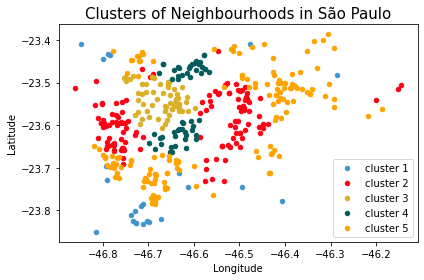

In [141]:
import matplotlib.pyplot as plt
import numpy as np

city = cities['sp']

conditions = df_cluster['city'] == city['name']
conditions &= (df_cluster['latitude'] > city['lat_min']) & (df_cluster['latitude'] < city['lat_max'])
conditions &= (df_cluster['longitude'] > city['long_min']) & (df_cluster['longitude'] < city['long_max'])
df_cat = df_cluster[conditions]

for lab in  np.sort(df_cat['labels'].unique()):
    df_plot = df_cat[df_cat['labels']==lab]
    plt.scatter(df_plot['longitude'],df_plot['latitude'],c=colors_list[lab],s=20,label='cluster '+str(lab))
    
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clusters of Neighbourhoods in '+city['name'], fontsize=15)
plt.tight_layout()
plt.savefig('clusters_of_neighbourhood-sp.png')
plt.show()

In [41]:
import random
from IPython.core.display import display, HTML

city = cities['sp']


geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(city['name'])
latitude = location.latitude
longitude = location.longitude

# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)


# add markers to map
for (lat, lng, neighborhood,lab,col) in zip(df_cat['latitude'], df_cat['longitude'], df_cat['neighbourhood'], df_cat['labels'], df_cat['color']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=col,
        fill=True,
        fill_color=col,
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

file = 'map.html'

map_toronto.save(file)
display(HTML('<a href="'+file+ '" target="_blank">Click here to see the map.</a>'))

map_toronto

## Rio de Janeiro

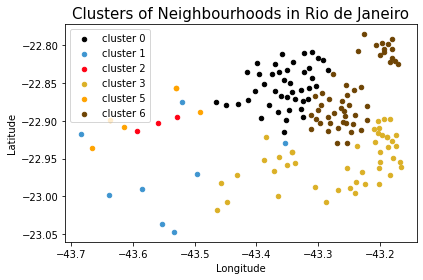

In [44]:
city = cities['rj']

conditions = df_cluster['city'] == city['name']
conditions &= (df_cluster['latitude'] > city['lat_min']) & (df_cluster['latitude'] < city['lat_max'])
conditions &= (df_cluster['longitude'] > city['long_min']) & (df_cluster['longitude'] < city['long_max'])
df_cat = df_cluster[conditions]

for lab in  np.sort(df_cat['labels'].unique()):
    df_plot = df_cat[df_cat['labels']==lab]
    plt.scatter(df_plot['longitude'],df_plot['latitude'],c=colors_list[lab],s=20,label='cluster '+str(lab))
    
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clusters of Neighbourhoods in '+city['name'], fontsize=15)
plt.tight_layout()
plt.savefig('clusters_of_neighbourhood-rj.png')
plt.show()

In [43]:
import random
from IPython.core.display import display, HTML


geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(city['name'])
latitude = location.latitude
longitude = location.longitude

# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)


# add markers to map
for (lat, lng, neighborhood,lab,col) in zip(df_cat['latitude'], df_cat['longitude'], df_cat['neighbourhood'], df_cat['labels'], df_cat['color']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=col,
        fill=True,
        fill_color=col,
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

file = 'map.html'

map_toronto.save(file)
display(HTML('<a href="'+file+ '" target="_blank">Click here to see the map.</a>'))

map_toronto

# Results

# Discussion

# Conclusion

In [1]:
import numpy as np
import pandas as pd
import requests


Using `pandas.read_html` to get a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name

In [2]:
df_codes = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]

# Only process the cells that have an assigned borough.
# Ignore cells with a borough that is Not assigned.
df_codes = df_codes[df_codes['Borough'] != 'Not assigned'].reset_index(drop=True)

# If a cell has a borough but a Not assigned  neighborhood,
# then the neighborhood will be the same as the borough.
df_codes['Neighbourhood'] = df_codes.apply(
    lambda x: x['Neighbourhood'] if x['Neighbourhood']!='Not assigned' else x['Borough'],axis=1)

# In order to utilize the Foursquare location data, we need
# to get the latitude and the longitude coordinates of each
# neighborhood.
df_geospatial = pd.read_csv('https://cocl.us/Geospatial_data')

# Joining datasets
df = df_codes.merge(df_geospatial,on="Postal Code",how="left")

In [3]:
df

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood. 

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium 

Insert credentials

In [5]:
CLIENT_ID = 'BELQR33E4XOD32YRUYPSXUVVVR3GTWECQU2TXT1IT2CS10DG' # your Foursquare ID
CLIENT_SECRET = '3CCUNF3DMCFDUTCTIBLUYA0JWVXANW2EQ0R0GV4L5X2UKDFF' # your Foursquare Secret
ACCESS_TOKEN = '3DAFXVUZH2QSV4ARG42A5EATNKI1PODQNMAKUZMI31XZWE25' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BELQR33E4XOD32YRUYPSXUVVVR3GTWECQU2TXT1IT2CS10DG
CLIENT_SECRET:3CCUNF3DMCFDUTCTIBLUYA0JWVXANW2EQ0R0GV4L5X2UKDFF


Define a function to query the venues for each neighbourhood

In [208]:
def get_nearby_venues(
    postal_code,
    borough,
    neighbourhood,
    latitude,
    longitude,
    radius = 500,
    limit = 100):
            
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        limit)

    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    return [{
        'postal_code': postal_code,
        'borough':borough,
        'neighbourhood':neighbourhood,
        'latitude': latitude,
        'longitude': longitude,
        'name': result['venue']['name'],
        'categories': [cat['name'] for cat in result['venue']['categories']],
#         'categories_full': result['venue']['categories']
        
    } for result in results]

Applying the `get_nearby_venues` to neighbourhoods 

In [210]:
from tqdm import tqdm

list_venues = []

# Get venues for each neighbourhood
for index, row in tqdm(df.iterrows(),total = len(df)):
    results = get_nearby_venues(
        str(row['Postal Code']), 
        str(row['Borough']), 
        str(row['Neighbourhood']), 
        row['Latitude'],
        row['Longitude'],
    )
    
    categories = []
    for result in results:
        categories += result['categories']
    
    list_venues.append({
        'postal_code': str(row['Postal Code']),
        'borough': str(row['Borough']),
        'neighbourhood': str(row['Neighbourhood']),
        'latitude': row['Latitude'],
        'longitude': row['Longitude'],
        'categories': pd.Series(categories,name = 'categories').value_counts().to_dict()
    })

100%|██████████| 103/103 [01:20<00:00,  1.28it/s]


Here, I want to write a function to get all possible categories

In [211]:
from functools import reduce
def get_category_values(venues):
    result = list(
        set(
            reduce(
                lambda x,y : x + y,
                [
                    list(venue['categories'].keys()) for venue in venues
                ]
            )
        )
    )
    
    result.sort()
    
    return result
    
category_values = get_category_values(list_venues)

With the categories, It is possible to get the most frequent words on neighbourhood venues

In [509]:
from collections import Counter 

def n_most_common_words(n,venues=list_venues):
        
    list_str = []
    
    for venue in venues:
        try:
            list_str.append(
                reduce(
                    lambda x,y: x+' '+y+' ',
                    [(key+' ')*value for key, value in venue['categories'].items()]
                )
            )

        except:
            pass


    concat_categories = reduce(lambda x,y: x+' '+y+' ',list_str)

    for char in ['/','&']:
        concat_categories = concat_categories.replace(char,'')

    return dict(Counter(concat_categories.split()).most_common(n))

most_common_words = n_most_common_words(250)


Count the words in venues of each neighbourhood

In [510]:
def get_venue_feature_array(venue):

    result = {
        'postal_code': str(venue['postal_code']),
        'borough': str(venue['borough']),
        'neighbourhood': str(venue['neighbourhood']),
        'latitude': venue['latitude'],
        'longitude': venue['longitude'],
    }
    
    result.update(dict([(key,0) for key in most_common_words.keys()]))

    for key, value in venue['categories'].items():
        for word in key.split():
            if word in result.keys(): result[word] += value
                
    return result

venues_array = [get_venue_feature_array(venue) for venue in list_venues]
df_cat = pd.DataFrame(venues_array)

df_cat.head()


,postal_code,borough,neighbourhood,latitude,longitude,Restaurant,Shop,Store,Coffee,Place,Bar,Café,Food,Pizza,Park,Gym,Bakery,Italian,Hotel,Sandwich,American,Japanese,Clothing,Joint,Fast,Grocery,Sushi,Bank,Pub,Beer,Pharmacy,Theater,Breakfast,Spot,Seafood,Thai,Market,Gastropub,Center,Diner,Tea,Vegetarian,Vegan,Art,Studio,Deli,Bodega,Intersection,Fried,Chicken,Eastern,Bookstore,Station,Cocktail,Gallery,Mexican,Burrito,Sporting,Goods,Ice,Steakhouse,Liquor,Asian,Yoga,Dessert,Home,Chinese,Cream,Burger,Juice,Convenience,Greek,Brewery,Indian,Furniture,Middle,Lounge,Salad,Arts,Farmers,Fitness,Wine,Cosmetics,Department,Discount,Airport,Venue,French,Vietnamese,Salon,Museum,Court,Electronics,Bubble,Movie,Shopping,Mall,Pet,Service,Spa,Creperie,Caribbean,New,Room,Supermarket,Barbershop,Fish,Stadium,Concert,Hall,Gift,Ramen,Plaza,Bus,Comfort,Club,College,General,Music,Sports,European,Game,Jazz,Playground,Field,Cheese,Mediterranean,Latin,Baseball,Garden,Pool,Crafts,Skating,Rink,Irish,Tailor,Truck,Trail,Basketball,Gourmet,Gas,Jewelry,Men's,Aquarium,Line,Drink,Portuguese,Performing,Distribution,Space,Miscellaneous,Boutique,Entertainment,Smoothie,Athletics,Lingerie,Smoke,Video,Bistro,Fountain,Neighborhood,Nightclub,Bagel,Korean,Business,Poke,Mobile,Phone,Speakeasy,House,Gluten-free,Gay,Light,Rail,Antique,Event,Comic,Modern,Office,Construction,Landscaping,BBQ,Rental,Car,Location,Health,Chips,Falafel,Dog,Run,Noodle,Toy,Scenic,Lookout,History,Monument,Landmark,Train,Hockey,Arena,Chocolate,Shoe,Flea,Poutine,Ethiopian,Tanning,Lake,Metro,Bike,Stop,Moroccan,Belgian,Donut,Colombian,Soup,Building,Cupcake,Frozen,Yogurt,Roof,Deck,Dance,IT,Services,Indie,Record,Cuban,Hobby,Travel,Butcher,School,Flower,Auto,Gaming,Cafe,Terminal,Sculpture,Historic,Site,Accessories,Auditorium,Cafeteria,Print,Rec,Hookah,Other,Great,Outdoors,Moving,Target,Dim,Sum,Curling,German,Medical
0,M3A,North York,Parkwoods,43.753259,-79.329656,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,M4A,North York,Victoria Village,43.725882,-79.315572,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,5,13,3,8,0,0,2,0,0,3,1,3,0,0,0,0,0,0,0,0,0,0,1,3,1,0,2,2,2,0,0,1,0,2,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1,2,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## Clusterization

In [516]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()


venues_array = [get_venue_feature_array(venue) for venue in list_venues]
df_cat = pd.DataFrame(venues_array)

df_cat.iloc[:,5:] = scaler.fit_transform(df_cat.iloc[:,5:])

kclusters = 4

# # run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_cat.iloc[:,5:])

# # check cluster labels generated for each row in the dataframe
df_cat['labels'] = kmeans.labels_

colors_list = ['#000000','#3f95d0','#ff0114','#dbb027','#ffa300','#045c5c',]
df_cat['color'] = df_cat['labels'].apply(lambda x: colors_list[x])

For each cluster, get the most frequent words

In [515]:
df_gr = df_cat.iloc[:,5:-1].groupby('labels').mean()
resut = []
for lab in df_gr.index:
    list_ven = df_gr.iloc[lab].sort_values(ascending=False)
    list_ind = list_ven.index
    dict_res = {'label': lab}

    for i in range(len(list_ven)): dict_res.update({'word_'+str(i): list_ind[i]})

    resut.append(dict_res)
pd.DataFrame(resut)

,label,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,word_10,word_11,word_12,word_13,word_14,word_15,word_16,word_17,word_18,word_19,word_20,word_21,word_22,word_23,word_24,word_25,word_26,word_27,word_28,word_29,word_30,word_31,word_32,word_33,word_34,word_35,word_36,word_37,word_38,word_39,word_40,word_41,word_42,word_43,word_44,word_45,word_46,word_47,word_48,word_49,word_50,word_51,word_52,word_53,word_54,word_55,word_56,word_57,word_58,word_59,word_60,word_61,word_62,word_63,word_64,word_65,word_66,word_67,word_68,word_69,word_70,word_71,word_72,word_73,word_74,word_75,word_76,word_77,word_78,word_79,word_80,word_81,word_82,word_83,word_84,word_85,word_86,word_87,word_88,word_89,word_90,word_91,word_92,word_93,word_94,word_95,word_96,word_97,word_98,word_99,word_100,word_101,word_102,word_103,word_104,word_105,word_106,word_107,word_108,word_109,word_110,word_111,word_112,word_113,word_114,word_115,word_116,word_117,word_118,word_119,word_120,word_121,word_122,word_123,word_124,word_125,word_126,word_127,word_128,word_129,word_130,word_131,word_132,word_133,word_134,word_135,word_136,word_137,word_138,word_139,word_140,word_141,word_142,word_143,word_144,word_145,word_146,word_147,word_148,word_149,word_150,word_151,word_152,word_153,word_154,word_155,word_156,word_157,word_158,word_159,word_160,word_161,word_162,word_163,word_164,word_165,word_166,word_167,word_168,word_169,word_170,word_171,word_172,word_173,word_174,word_175,word_176,word_177,word_178,word_179,word_180,word_181,word_182,word_183,word_184,word_185,word_186,word_187,word_188,word_189,word_190,word_191,word_192,word_193,word_194,word_195,word_196,word_197,word_198,word_199,word_200,word_201,word_202,word_203,word_204,word_205,word_206,word_207,word_208,word_209,word_210,word_211,word_212,word_213,word_214,word_215,word_216,word_217,word_218,word_219,word_220,word_221,word_222,word_223,word_224,word_225,word_226,word_227,word_228,word_229,word_230,word_231,word_232,word_233,word_234,word_235,word_236,word_237,word_238,word_239,word_240,word_241,word_242,word_243,word_244,word_245,word_246,word_247,word_248,word_249
0,0,Room,Shop,Coffee,Bar,Wine,Chinese,Juice,Bank,Salon,Office,Spa,Restaurant,Tea,Joint,Ice,Cream,Burger,Store,Japanese,Bubble,Theater,Place,Clothing,European,Food,Distribution,Miscellaneous,Boutique,Ethiopian,Lake,Smoke,Video,Arts,New,Fitness,Korean,Diner,Barbershop,Movie,Department,Dance,Discount,Comic,Modern,Intersection,Italian,Fast,Sandwich,Café,Studio,Center,Bakery,Park,Art,Yoga,Burrito,Electronics,Men's,Pizza,Museum,Indian,Baseball,Game,Music,Plaza,Court,Sushi,Middle,Goods,Sporting,Cosmetics,Ramen,Venue,Eastern,Gastropub,Furniture,Sports,Pharmacy,Donut,Field,Salad,Mediterranean,Lounge,Skating,Yogurt,Rink,Brewery,Convenience,Thai,Fried,Basketball,Tanning,Frozen,Roof,Jewelry,Sculpture,Mall,Outdoors,Great,Other,Hookah,Rec,Supermarket,Hotel,Club,Stadium,French,School,Indie,Services,IT,Deck,Poutine,Shopping,Shoe,Lookout,Scenic,Aquarium,Toy,Run,Business,Poke,Mobile,Phone,Dog,Gallery,Gay,Bookstore,Falafel,Chicken,Health,Bistro,Neighborhood,Home,Landmark,Dessert,Performing,Portuguese,Train,Drink,Chocolate,Monument,Liquor,Steakhouse,Lingerie,History,Gym,Service,Deli,Beer,American,Mexican,Pub,Bodega,Station,Seafood,Vegan,Spot,Breakfast,Vegetarian,Garden,Caribbean,Creperie,College,Vietnamese,Asian,Grocery,Bike,Cupcake,Building,Soup,Colombian,Belgian,Moroccan,Stop,Pet,Market,Metro,Record,Arena,Hockey,Noodle,Chips,Location,Car,Flea,Hobby,Cuban,Accessories,Curling,Sum,Dim,Target,Moving,Print,Cafeteria,Auditorium,Site,BBQ,Historic,Terminal,Cafe,Gaming,Auto,Flower,Butcher,Travel,Rental,Event,Landscaping,Tailor,Irish,Crafts,Pool,German,Latin,Cheese,Playground,Farmers,Jazz,General,Comfort,Bus,Airport,Gift,Hall,Concert,Fish,Greek,Truck,Construction,Trail,Antique,Rail,Light,Cocktail,Gluten-free,House,Speakeasy,Bagel,Nightclub,Fountain,Athletics,Smoothie,Entertainment,Space,Line,Gas,Gourmet,Medical
1,1,Intersection,Park,Liquor,Convenien

Plotting the clusters

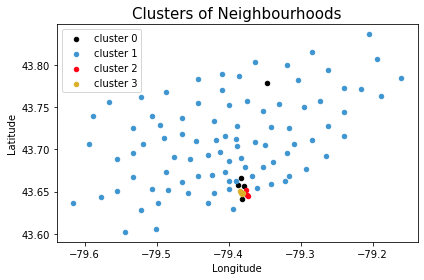

In [520]:
import matplotlib.pyplot as plt
for lab in  np.sort(df_cat['labels'].unique()):
    df_plot = df_cat[df_cat['labels']==lab]
    plt.scatter(df_plot['longitude'],df_plot['latitude'],c=colors_list[lab],s=20,label='cluster '+str(lab))
    
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clusters of Neighbourhoods', fontsize=15)
plt.tight_layout()
plt.savefig('clusters_of_neighbourhood.png')
plt.show()

Plotting the Map

In [517]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [519]:
import random
from IPython.core.display import display, HTML

# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)


# add markers to map
for (lat, lng, borough, neighborhood,lab,col) in zip(df_cat['latitude'], df_cat['longitude'], df_cat['borough'], df_cat['neighbourhood'], df_cat['labels'], df_cat['color']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=col,
        fill=True,
        fill_color=col,
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

file = 'map.html'

map_toronto.save(file)
display(HTML('<a href="'+file+ '" target="_blank">Click here to see the map.</a>'))

map_toronto